In [1]:
%matplotlib inline

import sys

sys.path.append("..")

In [2]:
import torch
torch.cuda._lazy_init() # avoid "Unknown CUDA error"
torch.cuda.is_available()

True

In [3]:
# Load the Dataset class
from torchvision import transforms

from settings import DATA_SOURCES
from src.datasets.sketchy import Sketchy

# dataset = Sketchy(DATA_SOURCES['sketchy_test']['photos'], transforms.Grayscale(num_output_channels=1))
dataset = Sketchy(DATA_SOURCES['sketchy_test']['photos'])
len(dataset)

1250

In [4]:
# from torchvision.datasets import ImageFolder

# # load with a grayscale transform
# dataset = ImageFolder(
#     root=DATA_SOURCES['sketchy_test']['photos'],
#     transform=transforms.Compose([
#         transforms.Resize(DATA_SOURCES['sketchy']['dimensions'][0]),
#         transforms.CenterCrop(DATA_SOURCES['sketchy']['dimensions'][0]),
#         transforms.Grayscale(num_output_channels=1),
#         transforms.ToTensor(),
# #         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#     ])
# )

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torchvision.utils as vutils

# # Plot some training images
# image = dataset[0]
# plt.figure(figsize=(4,4))
# plt.axis("off")
# plt.title("Class: %s" % image[1])
# plt.imshow(np.transpose(vutils.make_grid(image[0].to(device), padding=2, normalize=True).cpu(), (1,2,0)))

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Number of workers for dataloader
workers = 8

# Batch size for dataloader
batch_size = 1

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

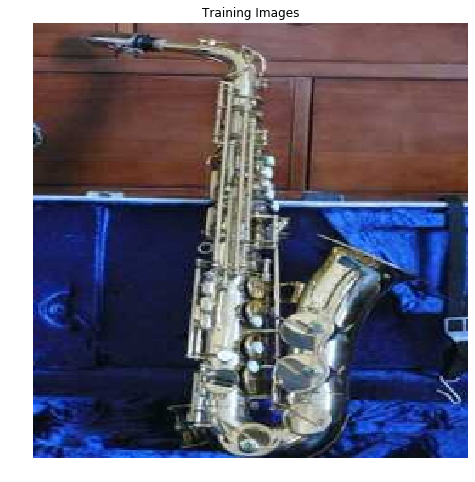

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Create the dataloader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Plot some training images
real_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
inputs, labels = next(iter(data_loader))
inputs.shape

torch.Size([1, 3, 256, 256])

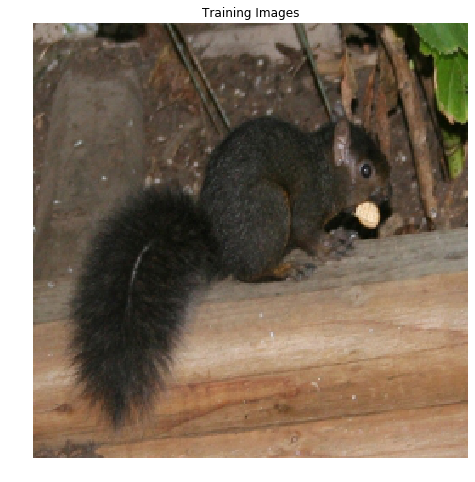

In [7]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(inputs[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

First, a benchmark with OpenCV

In [10]:
# import cv2

# img = inputs[0].numpy()
# sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=1)

In [ ]:
# import matplotlib.pyplot as plt

# plt.imshow(sobelx[0], cmap = 'gray')

In [8]:
from src.models.gradients import SobelX, SobelY

sobel_x = SobelX()
sobel_y = SobelY()

In [9]:
out = sobel_x(inputs)
out.shape

torch.Size([1, 1, 256, 256])

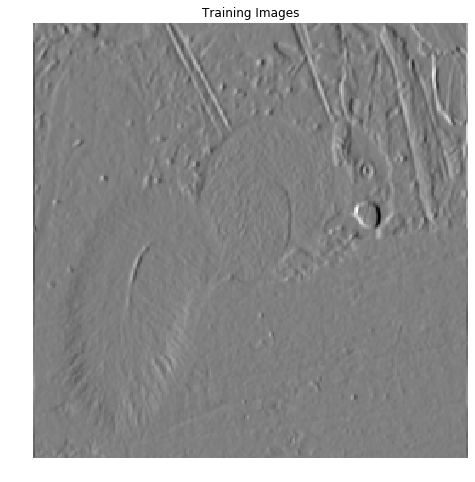

In [10]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(out[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Nice. Now for the HOG.

In [11]:
import torch

gx = sobel_x(inputs)
gy = sobel_y(inputs)

mag = torch.sqrt(gx**2 + gy**2)
ang = torch.atan2(gx, gy)

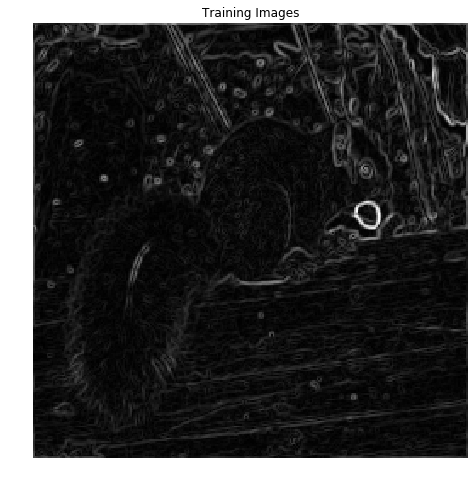

In [12]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(mag[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

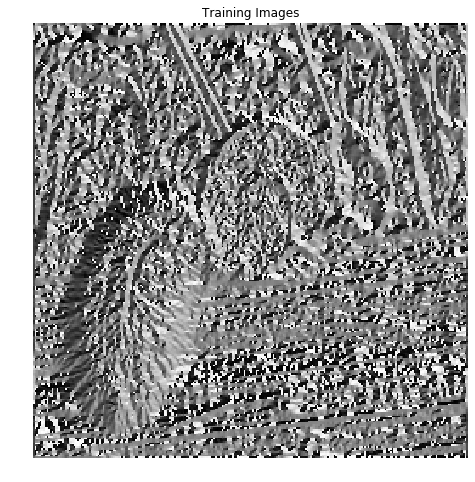

In [13]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(ang[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
from src.models.hog import HOG

net = HOG()

In [8]:
net(inputs)

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])

In [10]:
import cv2

gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)

NameError: name 'img' is not defined

In [ ]:
for i, data in enumerate(data_loader, 0): # iterate batches
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    print(inputs)
#     outputs = net(inputs)